In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cProfile import label #?not sure
import re
from fuzzywuzzy import fuzz
import difflib 
from fuzzywuzzy import process
import time
from tqdm import tqdm
import fitz

from functools import reduce
from fitz.utils import getColor

In [2]:
vol1_path = '../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf'
vol2_path = '../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 2.pdf'
vol3_path = '../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 3.pdf'

vol1_doc = fitz.open(vol1_path)
vol2_doc = fitz.open(vol2_path)
vol3_doc = fitz.open(vol3_path)

vol1_pages = [vol1_doc[i] for i in range(vol1_doc.page_count)]
vol2_pages = [vol2_doc[i] for i in range(vol2_doc.page_count)]
vol3_pages = [vol3_doc[i] for i in range(vol3_doc.page_count)]

In [3]:
vol1_char_df = pd.read_pickle("../input/char_df/vol1_df.pkl")
vol2_char_df = pd.read_pickle("../input/char_df/vol2_df.pkl")
vol3_char_df = pd.read_pickle("../input/char_df/vol3_df.pkl")

In [4]:
#mout. index: 
vol1_index_path = '../output/local/index_output/vol1_nonitalics.csv'
vol2_index_path = '../output/local/index_output/vol2_nonitalics.csv'
vol3_index_path = '../output/local/index_output/vol3_nonitalics.csv'

vol1_index_df = pd.read_csv(vol1_index_path)
vol2_index_df = pd.read_csv(vol2_index_path)
vol3_index_df = pd.read_csv(vol3_index_path)

#changing name of columns of mout. indecies 
vol1_index_df.rename(columns={'closest_genus': 'mouterde_genus', 'closest_epithet': 'mouterde_epithet', 'authors':'mouterde_author', 'closest_infra_name':'mouterde_infra'}, inplace=True)
vol2_index_df.rename(columns={'closest_genus': 'mouterde_genus', 'closest_epithet': 'mouterde_epithet', 'authors':'mouterde_author', 'closest_infra_name':'mouterde_infra'}, inplace=True)
vol3_index_df.rename(columns={'closest_genus': 'mouterde_genus', 'closest_epithet': 'mouterde_epithet', 'authors':'mouterde_author', 'closest_infra_name':'mouterde_infra'}, inplace=True)

In [5]:
vol1_word_df = vol1_char_df.loc[:, ['vol_num', 'page_num', 
                                    'block_num', 'block_num_absolute', 'block_bbox',
                                    'line_num', 'line_wmode', 'line_dir', 'line_bbox', 
                                    'span_num', 'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender', 'span_descender', 'span_origin', 'span_bbox', 
                                    'word_num', 'word','word_bbox', 'pruned_word', 'pruned_word_bbox']].drop_duplicates()

vol2_word_df = vol2_char_df.loc[:, ['vol_num', 'page_num', 
                                    'block_num', 'block_num_absolute', 'block_bbox',
                                    'line_num', 'line_wmode', 'line_dir', 'line_bbox', 
                                    'span_num', 'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender', 'span_descender', 'span_origin', 'span_bbox', 
                                    'word_num', 'word','word_bbox', 'pruned_word', 'pruned_word_bbox']].drop_duplicates()

vol3_word_df = vol3_char_df.loc[:, ['vol_num', 'page_num', 
                                    'block_num', 'block_num_absolute', 'block_bbox',
                                    'line_num', 'line_wmode', 'line_dir', 'line_bbox', 
                                    'span_num', 'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender', 'span_descender', 'span_origin', 'span_bbox', 
                                    'word_num', 'word','word_bbox', 'pruned_word', 'pruned_word_bbox']].drop_duplicates()

In [6]:
#list of genera from index -- uppercased to match main text pattern
vol1_genera = vol1_index_df[vol1_index_df['taxon_rank'] == 'genus']['mouterde_genus'].str.upper().tolist()

#list of species binomial from main text
vol1_species_temp_df = vol1_index_df[(vol1_index_df['taxon_rank'] == 'epithet') & (~vol1_index_df['mouterde_genus'].isna())]
vol1_species_binomial_list = list(zip(vol1_species_temp_df['mouterde_genus'], vol1_species_temp_df['mouterde_epithet']))
vol1_species = list(map(lambda x: f"{x[0]} {x[1]}", vol1_species_binomial_list))
vol1_species_abriviation = list(map(lambda x: f"{x[0][0]}. {x[1]}", vol1_species_binomial_list))

In [7]:
def is_italic(flags):
    return flags & 2 ** 1 != 0

In [8]:
def get_n_words_flagged(df, n, inplace = True):
    #assumes n > 1
    out_words_col = f"{n}_words"
    out_flags_col = f"{n}_flags"
    
    line_group_cols = ['vol_num', 'page_num', 
                       'block_num', 'block_num_absolute', 'block_bbox', 
                       'line_num', 'line_wmode', 'line_dir', 'line_bbox']
    
    n_words_lists = [None for i in range(n)]
    n_words_flags = [None for i in range(n)]

    n_words_lists[0] = df['word']
    n_words_flags[0] = df['span_flags']

    for i in range(1, n):
        n_words_lists[i] = df.groupby(line_group_cols)['word'].shift(-i, fill_value="")
        n_words_flags[i] = df.groupby(line_group_cols)['span_flags'].shift(-i, fill_value=0)

    zip_n_words = list(zip(*n_words_lists))
    n_word_string = list(map(lambda n_word_list : " ".join(n_word_list), zip_n_words))

    zip_n_flags = list(zip(*n_words_flags))
    combine_flags = list(map(lambda flag_list : reduce(lambda x, y: x | y, flag_list), zip_n_flags))
    
    if inplace == True:
        df[out_words_col] = n_word_string
        df[out_flags_col] = combine_flags
    return n_word_string, combine_flags

In [9]:
tqdm.pandas()

In [11]:
vol1_word_df = pd.read_pickle("../input/desc_box_df/vol1_desc_df_v2.pkl")

In [13]:
vol1_word_df.columns

Index(['vol_num', 'page_num', 'block_num', 'block_num_absolute', 'block_bbox',
       'line_num', 'line_wmode', 'line_dir', 'line_bbox', 'span_num',
       'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender',
       'span_descender', 'span_origin', 'span_bbox', 'word_num', 'word',
       'word_bbox', 'pruned_word', 'pruned_word_bbox', '1_words', '1_flags',
       '1_words_match', '1_words_match_score', '2_words', '2_flags',
       '2_words_match', '2_words_match_score', '3_words', '3_flags',
       '3_words_match', '3_words_match_score', '4_words', '4_flags',
       '4_words_match', '4_words_match_score', 'line_id', 'is_page_title',
       'page_title_mean_y', 'is_title_line', 'section_break', 'section_id',
       'section_start_y', 'section_bbox', 'binom_section'],
      dtype='object')

In [16]:
is_binomial = ((~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['2_flags'].apply(is_italic)) & (vol1_word_df['2_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['3_flags'].apply(is_italic)) & (vol1_word_df['3_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85))) 
binom_page_num = vol1_word_df[(is_binomial)]['page_num']
binom_block_num = vol1_word_df[(is_binomial)]['block_num']
binom_line_num = vol1_word_df[(is_binomial)]['line_num']
binom_id = list(zip(binom_page_num, binom_block_num, binom_line_num))

In [20]:
vol1_char_df['line_id'] = vol1_char_df.apply(lambda r : (r['page_num'], r['block_num'], r['line_num']), axis = 1)
vol1_char_binom_df = vol1_char_df[vol1_char_df['line_id'].isin(binom_id)]

In [24]:
binom_char_width = vol1_char_binom_df.groupby('line_id')['char_bbox'].transform(lambda x: x.apply(lambda y: y[2] - y[0])).mean()
binom_char_width

4.925233924113611

In [32]:
num_pages = vol1_word_df['page_num'].max() + 1
for page_num in tqdm(range(num_pages)):
    vol1_word_df.loc[vol1_word_df['page_num'] == page_num, 'mean_binom_x0'] = vol1_word_df[(vol1_word_df['page_num'] == page_num) & (vol1_word_df['line_id'].isin(binom_id))]['line_bbox'].apply(lambda x : x[0]).mean()

100%|██████████| 642/642 [00:06<00:00, 97.81it/s]


In [60]:
accepted_error = (binom_char_width)*2.5 #just eyeballing it ...

def is_binom_indentation(row):
    if abs(row['mean_binom_x0'] - (row['line_bbox'][0])) < accepted_error:
        return True
    else:
        return False

vol1_word_df['is_binom_indentation'] = vol1_word_df.progress_apply(is_binom_indentation, axis = 1)

100%|██████████| 314517/314517 [00:01<00:00, 217661.06it/s]


In [61]:
vol1_word_df['section_break']

0          False
6          False
14         False
16         False
20         False
           ...  
1761774     True
1761781     True
1761784     True
1761788     True
1761792     True
Name: section_break, Length: 314517, dtype: bool

In [63]:
vol1_word_df['paragraph_id'] = np.nan
def paragraph_id(row):
    if row['is_binom_indentation'] == True:
        return row['line_id']
    if row['section_break'] == True:
        return row['line_id']
    else:
        return np.nan

vol1_word_df['paragraph_id'] = vol1_word_df.progress_apply(paragraph_id, axis = 1)
vol1_word_df['paragraph_id'].ffill(inplace=True)

100%|██████████| 314517/314517 [00:01<00:00, 219108.09it/s]


In [64]:
# break down line coords
vol1_word_df['line_x0'] = vol1_word_df["line_bbox"].apply(lambda x: x[0])
vol1_word_df['line_y0'] = vol1_word_df["line_bbox"].apply(lambda x: x[1])
vol1_word_df['line_x1'] = vol1_word_df["line_bbox"].apply(lambda x: x[2])
vol1_word_df['line_y1'] = vol1_word_df["line_bbox"].apply(lambda x: x[3])

#sections_coords: 
vol1_word_df["paragraph_x0"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_x0'].transform('min')
vol1_word_df["paragraph_y0"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_y0'].transform('min')
#vol1_word_df["section_y0"] = vol1_word_df[['section_y0_all','section_y0_all']].max(axis=1)
vol1_word_df["paragraph_x1"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_x1'].transform('max')
vol1_word_df["paragraph_y1"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_y1'].transform('max')

#section_bbox:
vol1_word_df["paragraph_bbox"] = vol1_word_df.apply(lambda r: (r["paragraph_x0"], r["paragraph_y0"], r["paragraph_x1"], r["paragraph_y1"]), axis = 1)

#drop extra cols:
vol1_word_df.drop(columns= ["line_x0", "line_y0", "line_x1", "line_y1", "paragraph_x0", "paragraph_y0", "paragraph_x1", "paragraph_y1"], inplace = True)

In [87]:
vol1_doc = fitz.open(vol1_path)
vol2_doc = fitz.open(vol2_path)
vol3_doc = fitz.open(vol3_path)

for page_num in tqdm(range(num_pages)):
    section_groups = vol1_word_df[vol1_word_df['page_num'] == page_num].groupby('section_id')
    page = vol1_doc[page_num]
    colors = [getColor("plum"), getColor("orchid4")]
    
    paragraph_groups = vol1_word_df[vol1_word_df['page_num'] == page_num].groupby('paragraph_id')
    for name, paragraph in paragraph_groups:
        i = 0
        paragraph_id = paragraph.iloc[0]['paragraph_id']
        paragraph_section_id = paragraph.iloc[0]['section_id']
        paragraph_bbox = paragraph.iloc[0]['paragraph_bbox']
        is_L_loc = paragraph.iloc[0]['word'].lower() in ["l.", "l"]
        is_S_loc = paragraph.iloc[0]['word'].lower() in ["s.", "s"]
        
        c = getColor("lightgray")
        if is_L_loc: 
            c = getColor("lightblue")
        if is_S_loc:
            c = getColor("pink")
        if paragraph_section_id in binom_id:
            r_box = fitz.Rect(paragraph_bbox)
            annot_rect = page.add_rect_annot(r_box)
            annot_rect.set_colors({"stroke":c})
            annot_rect.update()
            i += 1
        c = getColor("lightgray")

    for name, section in section_groups:
        section_id = section.iloc[0]['section_id']
        section_bbox = section.iloc[0]['section_bbox']
        if section_id in binom_id:
            r_box = fitz.Rect(section_bbox)
            #r_box.set_stroke_color(stroke=getColor("violetred4"))
            annot_rect = page.add_rect_annot(r_box)
            annot_rect.set_colors({"stroke": getColor("violetred4")})
            annot_rect.update()

marked_epithet_fname = "../output/local/main_text/binom_sections_paragraphs_LS_v1.pdf"
vol1_doc.save(marked_epithet_fname)

100%|██████████| 642/642 [00:03<00:00, 178.13it/s]


### current problems

page 110 -- no binom in page -- not catagorizing paragraphs as expected / hoped
page 275 -- above ^ 
page 97 -- L. et S. 
page 107 -- 2.5 error margin seems too wide ... 
page 127 -- Phalaris caerulescens -> . L. Ct. ....
what to do with stuff like 153 
how important is italics entries being in good entries (eg 160)

265 is being picked up correctly which is *happy*
271 sy. Sy. «Tell près de Zraikiyé, au nord de Sanamein», décembre 1954 (Hauran). Legit PABOT. Typus: Herbier Mouterde P 326

real issue : 276 : start of binomial issue: "'-^ Juncus effusus 
-- possible solution: for binomial x0, go based on word x0 for part that is the  
                      binomial matching part not the line match
-- possible solution for pages without binomials: add a column to keep track of distance 
                                                  between bbox and binomial name x0 (first solve above) and take the average of that value as binomial x0 then add that to the desired page's section bbox x0 

In [90]:
vol1_word_df.columns

Index(['vol_num', 'page_num', 'block_num', 'block_num_absolute', 'block_bbox',
       'line_num', 'line_wmode', 'line_dir', 'line_bbox', 'span_num',
       'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender',
       'span_descender', 'span_origin', 'span_bbox', 'word_num', 'word',
       'word_bbox', 'pruned_word', 'pruned_word_bbox', '1_words', '1_flags',
       '1_words_match', '1_words_match_score', '2_words', '2_flags',
       '2_words_match', '2_words_match_score', '3_words', '3_flags',
       '3_words_match', '3_words_match_score', '4_words', '4_flags',
       '4_words_match', '4_words_match_score', 'line_id', 'is_page_title',
       'page_title_mean_y', 'is_title_line', 'section_break', 'section_id',
       'section_start_y', 'section_bbox', 'binom_section', 'mean_binom_x0',
       'is_binom_indentation', 'paragraph_id', 'paragraph_bbox'],
      dtype='object')

In [89]:
vol1_word_df['pruned_word']

0               AUTRES
6             OUVRAGES
14                  DU
16                MÊME
20              AUTEUR
              ...     
1761774        JUILLET
1761781            MIL
1761784           NEUF
1761788           CENT
1761792    SOIXANTESIX
Name: pruned_word, Length: 314517, dtype: object

In [84]:
[getColor("darkpink"), getColor("lightblue")]

[(1, 1, 1), (0.6784313725490196, 0.8470588235294118, 0.9019607843137255)]

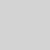

In [91]:
from PIL import Image

# Create a new image with a solid color
width = 50
height = 50
colors = [getColor("pink"), getColor("lightblue"),  getColor("lightgray")]
for color_1 in colors:
    color_255 = tuple(int(c_val*255) for c_val in color_1) # red color
    image = Image.new("RGB", (width, height), color_255)
    image.show()
# Display the image
image